In [439]:
# MODEL PARAMETERS

# Adjust model params here
num_runs = 5 # Number of times to run simulation
event_length = 5 
baseline_beta = 1
mitigation_beta = 1
prevalence = .5
prop_natural_immune = .2
pop = 1000
event_environment = "indoor" # "outdoor", "indoor", or "mixed"

# Booleans for choice of intervention
use_vaccines = False
use_testing = True
use_base_beta = False # Apply beta to baseline (temp for debugging)
use_mit_beta = False # Apply beta to comparison event ^^

# Testing params
test_del = 0 # Test delay (days)
days_testing = 0 # Number of days performing tests susceptibles
subtarg = None # Subtargetting of tests
sens = .98 # Sensitivity of test used
use_rapid = False # True for onsite rapid tests, False for reported tests
test_window = 2 # e.g if 2, negative test from <2 days prior to event required. Max 4

# Vaccine params
perc_vax = .2 # Percentage of population vaxxed
passport = True # True if 100% of attendees must be vaccinated
v_efficacy_inf = .2 # Vax efficacy against infection
v_efficacy_symp = .2 # Vax efficacy against symptoms
n_efficacy_inf = .3 # Natural immunity efficacy against infection
n_efficacy_symp = .2 # Natural immunity efficacy against symptoms


In [440]:
# IMPORTS
import covasim as cv
from datetime import date, timedelta

In [441]:
## Date Extraction
today = date.today()

# Function to format date into proper string
def format_day(date):
    return date.strftime("%Y-%m-%d")

In [442]:

# For time to death, should we just make it kill immediately by adjusting exp2inf and crit2die? Or add 30 days to simulation?

# Get start and end date of event, starting today
d1 = format_day(today)
d2 = format_day(today + timedelta(days = event_length))

# Initialize model parameters
pars = dict(
    start_day = d1,
    end_day   = d2,
    pop_type  = 'hybrid',
    pop_size = pop,
    pop_infected = pop * prevalence
)

""" test_intervention: Creates intervention for a testing strategy
-   test_del: Delay in test result
-   days_testing: Number of days in event testing susceptibles
-   subtarg: Indices of population to subtarget
-   sens: Sensitivity of test used
"""
# Note: this only works for cases generated at event. 
# For single entry testing only, run test_intervention(0,0)
def test_intervention(test_del, days_testing, subtarg=None, sens=1, rapid=True, window=2):

    if (rapid):
        pars['pop_infected'] -= sens * pars['pop_infected']
    else:
       # Newly infected are those infected after test (assume even distribution of test date from 1 to 'window' days ago)
       # Assume 12 days infectious, all tests within 4.6 day period from exposed->infectious (max window 4)
       # These people will test negative even with a perfect test, because they were exposed after testing negative
       
       num_preinfectious = prevalence * pop * sum([x*(1/(12*window)) for x in range(1,window+1)])

       # Finally, remove population that is detected by the reported tests
       pars['pop_infected'] += num_preinfectious - sens * pars['pop_infected']
    
    return cv.test_num(daily_tests=[pop]*days_testing, 
                       start_day=d1, 
                       subtarget=subtarg,
                       symp_test=0,
                       sensitivity=sens,
                       test_delay=test_del)

"""vaccine_intervention: Creates intervention for a vaccine-based entry strategy
- percent_vax: Percentage of overall population vaccinated
- passport: If true, 100% of attendees must be vaccinated
- efficacy_inf: Efficacy against infection
- efficacy_symp: Efficacy against symptoms
- Returns intervention 
"""
def vaccine_intervention(percent_vax, passport = False, efficacy_inf = .2, efficacy_symp = .2):
    if passport:
        percent_vax = 1
    return cv.vaccine(days=0, prob=percent_vax, rel_sus=efficacy_inf, rel_symp=efficacy_symp)






In [443]:
# INTERVENTIONS AND SIMULATIONS

# Shared interventions
end_of_event = cv.change_beta(days=[d2], changes=[0]) # Transmission stops after event ends
natural_immunity = vaccine_intervention(prop_natural_immune, False, n_efficacy_inf, n_efficacy_symp)

# Baseline interventions and simulation
base_interventions = [end_of_event, natural_immunity]

if (use_base_beta):
    event_baseline = cv.dynamic_pars(beta=dict(days=list(range(event_length)), vals=[baseline_beta]*(event_length)))
    base_interventions.append(event_baseline)

orig_sim = cv.Sim(pars, interventions=base_interventions, label='Baseline')
msim2 = cv.MultiSim(orig_sim)
msim2.run(n_runs=num_runs)
msim2.mean()

# Mitigation interventions and simulation
mit_interventions = [end_of_event, natural_immunity]
if (use_testing):
    test_int = test_intervention(test_del=test_del, days_testing=days_testing, sens=sens, rapid=use_rapid, window=test_window)
    mit_interventions.append(test_int)
if (use_vaccines):
    vc = vaccine_intervention(perc_vax, passport)
    mit_interventions.append(vc)
if (use_mit_beta):
    event_mitigate = cv.dynamic_pars(beta=dict(days=list(range(event_length)), vals=[mitigation_beta]*(event_length)))
    mit_interventions.append(event_mitigate)

sim = cv.Sim(pars, interventions=mit_interventions, label='With mitigation measures')
msim1 = cv.MultiSim(sim)
msim1.run(n_runs=num_runs)
msim1.mean()

Initializing sim with 1000 people for 5 daysInitializing sim with 1000 people for 5 daysInitializing sim with 1000 people for 5 daysInitializing sim with 1000 people for 5 daysInitializing sim with 1000 people for 5 days




  Running "Baseline": 2021-04-03 ( 0/5) (1.08 s)  •••————————————————— 17%
  Running "Baseline": 2021-04-03 ( 0/5) (1.14 s)  •••————————————————— 17%

  Running "Baseline": 2021-04-03 ( 0/5) (1.16 s)  •••————————————————— 17%
  Running "Baseline": 2021-04-03 ( 0/5) (1.18 s)  •••————————————————— 17%
Simulation "Baseline" summary:
     129 cumulative infections
      75 cumulative infectious
       0 cumulative tests
       0 cumulative diagnoses
       0 cumulative recoveries
      38 cumulative symptomatic cases
       1 cumulative severe cases
       0 cumulative critical cases
       0 cumulative deaths
       0 cumulative quarantined people

Simulation "Baseline" summary:
     125 cumulative infections
      79 cumulative infectious
       0 cumulative tests
  

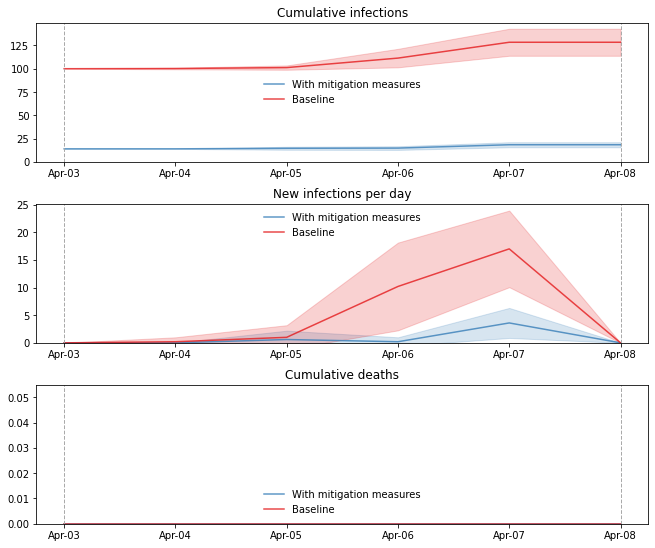

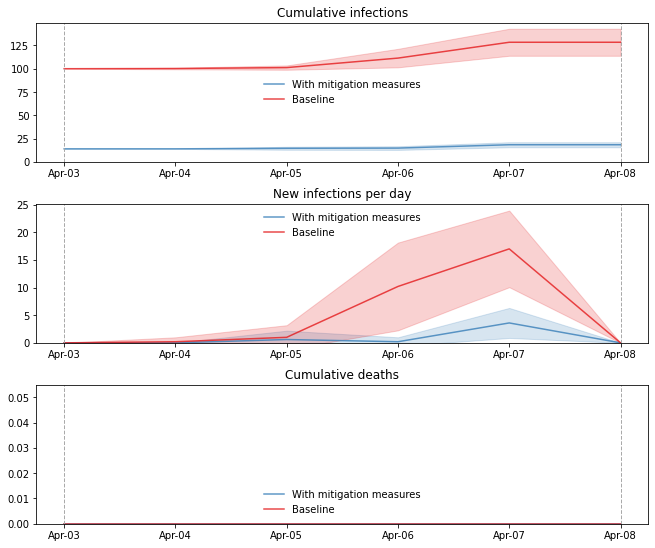

In [444]:
# RUN AND PLOT
msim = cv.MultiSim.merge([msim1, msim2], base=True)
msim.plot(color_by_sim=True)